In [12]:
#!/usr/bin/env python
# coding: utf-8

In [1]:
import cv2
import warnings
import numpy as np

from glob import glob
from tqdm import tqdm

from skimage import exposure, filters, measure, morphology, img_as_ubyte
from skimage.color import rgb2gray, gray2rgb
from skimage.io import imsave, imread

from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import statistics
import tifffile

In [2]:
warnings.filterwarnings('ignore')

In [3]:
def plot(arr_images=[], grid=(1, 1), cmap="inferno"):

    fig = plt.figure(figsize=(20, 10))

    grid = ImageGrid(fig, 111, nrows_ncols=grid,  axes_pad=0.1)

    for ax, img in zip(grid, arr_images):
        ax.imshow(img, cmap)
        ax.axis('off')

    plt.show()
    
    
def check_colision_border(mask):

    x, *_ = mask.shape

    left = mask[:1, ].flatten()
    right = mask[x - 1: x, ].flatten()
    top = mask[:, : 1].flatten()
    bottom = mask[:, x - 1: x].flatten()

    borders_flatten = [left, right, top, bottom]

    if np.concatenate(borders_flatten).sum(): return True
    return False   
    
    
def auto_invert_image_mask(arr):
    img = arr.copy()

    if statistics.mode(img.flatten()):
        img = np.invert(img)

    return img



def smoothing_mask_edges(mask):
    return binarize_image(filters.gaussian(mask, sigma=0.5))



def find_bighest_cluster_area(clusters):
    regions = measure.regionprops(clusters)

    all_areas = map(lambda item: item.area, regions)

    return max(all_areas)



def find_bighest_cluster(img):

    clusters = auto_invert_image_mask(img)

    clusters = measure.label(clusters, background=0)

    cluster_size = find_bighest_cluster_area(clusters)

    return morphology.remove_small_objects(clusters,
                                         min_size=(cluster_size - 1),
                                         connectivity=8)



def rescale_image(image, scale=255):
    return (image * scale).astype('uint8')
   
    
    
def im_read_gray(path):

    image = rgb2gray(tifffile.imread(path))
    
    return rescale_image(image)



def find_images(path):
    
    image_path = glob(path + '/*')
    
    image_index = filter(lambda x: 'back' not in x, image_path)
    background_index = filter(lambda x: 'back' in x, image_path)

    [background_path] = list(background_index)
    [image_path] = list(image_index)

    background = im_read_gray(background_path)    
    image = im_read_gray(image_path)
    
    return background, image

def binarize_image(image):
    return image > filters.threshold_yen(image)


def find_center_mask(image_bin):

    props, *_ = measure.regionprops(
      measure.label(image_bin)
    )

    x, y = props.centroid

    return int(x), int(y)



def crop_image_box(image, shape=(100, 100), margin_pixel=30):

    x, y = shape

    return image[x - margin_pixel:
                 x + margin_pixel,
                 y - margin_pixel:
                 y + margin_pixel]

In [4]:
def find_roi(back, image):
    image_diff =  binarize_image(np.subtract(image, back))

    image_diff_smoothed = filters.gaussian(image_diff, sigma=1)
    
    cluster = find_bighest_cluster(image_diff_smoothed)
    
    return auto_invert_image_mask(cluster)

def adaptive_threshold(image):
    return cv2.adaptiveThreshold(image, 
                             255,
                             cv2.ADAPTIVE_THRESH_MEAN_C,
                             cv2.THRESH_BINARY_INV, 
                             199,
                             1).astype(bool)

def segmenter(frame, background, simple_segmenter=True):

    image_diff = np.subtract(exposure.equalize_hist(frame), 
                             exposure.equalize_hist(background))

    if simple_segmenter:
        image_bin = binarize_image(image_diff)
    else:
        image_bin = adaptive_threshold(rescale_image(image_diff))
    
    cluster = find_bighest_cluster(image_bin)

    cluster_smoothed = smoothing_mask_edges(cluster)

    return auto_invert_image_mask(cluster_smoothed)

def auto_segmenter(image, back):
    
    mask = segmenter(image, back, simple_segmenter=False)

    if check_colision_border(mask):
        mask = segmenter(image, back, simple_segmenter=True)
        
    return mask

def define_barra_path():
    import os
    barra = "/"
    
    if os.name == 'nt':
        barra = "\\"
        
    return barra

In [5]:
## Criando backs na mBroilers/Conferidas/016/.tifão

In [6]:
# imsave('Broilers/Conferidas/016/back.tif', gray2rgb(tifffile.imread(('Broilers/Conferidas/016/016_background.tif'))))

## Testando 

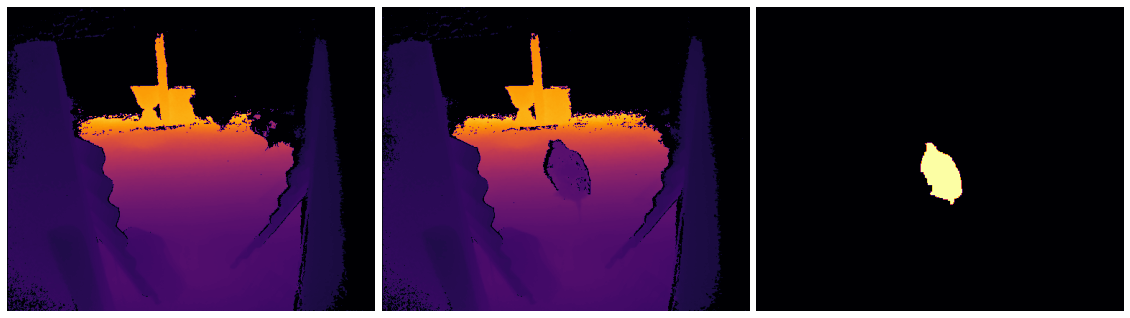

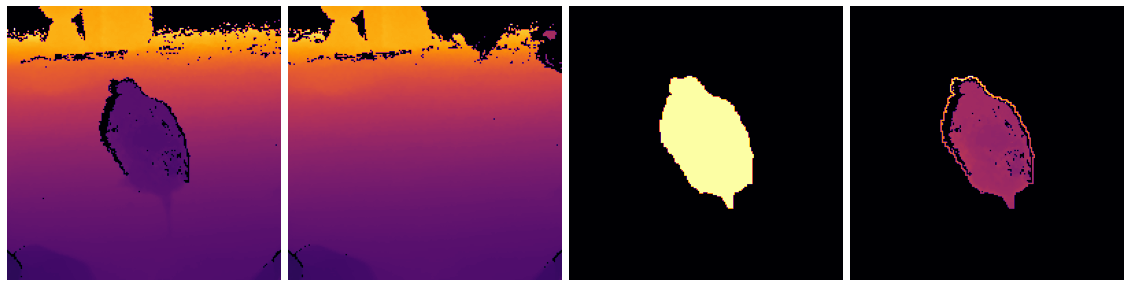

In [26]:
margin_pixel = 100

back, image = find_images(f'Broilers{define_barra_path()}Conferidas{define_barra_path()}138')

roi = find_roi(back, image)

plot([back, image, roi], (1, 3))

center_coords = find_center_mask(roi)

image_croped = crop_image_box(image,
                              center_coords,
                              margin_pixel)

back_croped = crop_image_box(back, 
                             center_coords,
                             margin_pixel)

mask = auto_segmenter(image_croped, back_croped)

plot([image_croped, back_croped, mask, image_croped * mask], (1, 4))

In [33]:
def run_segmenter(path_in,
                  path_image_out,
                  path_masks_out, 
                  func_segment,
                  margin_pixel=100):
    
    image_name = path_in.split(define_barra_path())[-1]
    
    try:
        back, image = find_images(path)

        roi = find_roi(back, image)

        center_coords = find_center_mask(roi)

        image_croped = crop_image_box(image,
                                      center_coords,
                                      margin_pixel)

        back_croped = crop_image_box(back, 
                                     center_coords,
                                     margin_pixel)

        mask = auto_segmenter(image_croped, back_croped)

        imsave(f'{path_image_out}{define_barra_path()}{image_name}.tif', img_as_ubyte(image_croped))
        imsave(f'{path_masks_out}{define_barra_path()}{image_name}.tif', img_as_ubyte(mask.astype(dtype=bool)))
    except Exception as e: 
        print(e, path_in)

In [37]:
import os

path_image_out = 'Segmentadas/images'
path_masks_out = 'Segmentadas/masks'

os.makedirs(path_masks_out)
os.makedirs(path_image_out)

for path in tqdm(sorted(glob("Broilers/Conferidas/*"))):
    run_segmenter(path_in=path,
                  path_image_out=path_image_out,
                  path_masks_out=path_masks_out,
                  func_segment=segmenter,
                  margin_pixel=100)   

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.07it/s]
